In [1]:
# MA Cross Backtesting on 1H BTC with following trade costs
# - Slippage is 0.5BPS
# - Taker fee is 0.04%
# - Initial capital is 5000.0$
# - Risk per trade is 5%
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df = yf.download('BTC-USD', interval='1h', period='12mo')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-10-01 21:00:00+00:00,19258.953125,19301.919922,19255.531250,19295.337891,19295.337891,0
2022-10-01 22:00:00+00:00,19294.972656,19326.589844,19286.642578,19323.523438,19323.523438,0
2022-10-01 23:00:00+00:00,19324.113281,19332.513672,19303.603516,19309.867188,19309.867188,0
2022-10-02 00:00:00+00:00,19311.849609,19322.921875,19271.833984,19289.521484,19289.521484,0
2022-10-02 01:00:00+00:00,19288.066406,19304.519531,19281.375000,19302.316406,19302.316406,0
...,...,...,...,...,...,...
2023-10-01 17:00:00+00:00,27116.236328,27144.445312,27066.039062,27078.275391,27078.275391,83597312
2023-10-01 18:00:00+00:00,27079.060547,27103.376953,27073.943359,27096.447266,27096.447266,59756032
2023-10-01 19:00:00+00:00,27097.894531,27112.117188,27085.472656,27105.357422,27105.357422,33827840


<Axes: xlabel='Datetime'>

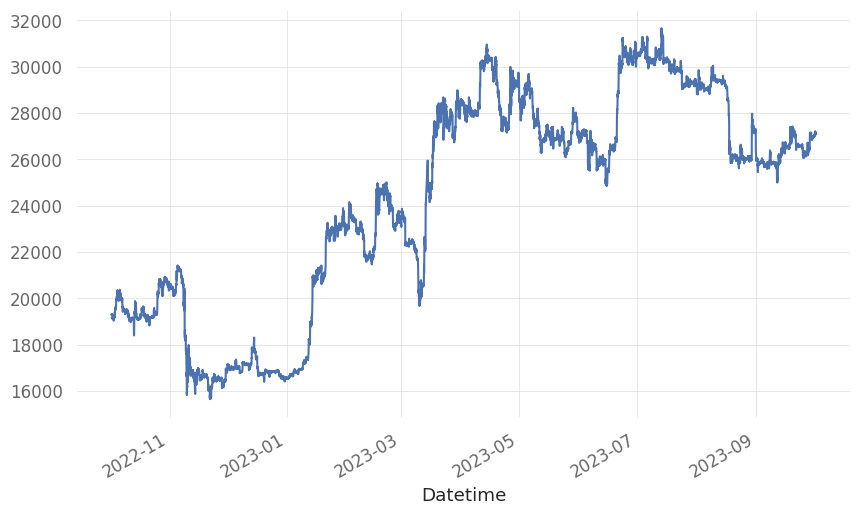

In [4]:
df['Close'].plot()

In [5]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=50 ).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [6]:
df['Signal'].value_counts()

Signal
 0    8673
 1      34
-1      33
Name: count, dtype: int64

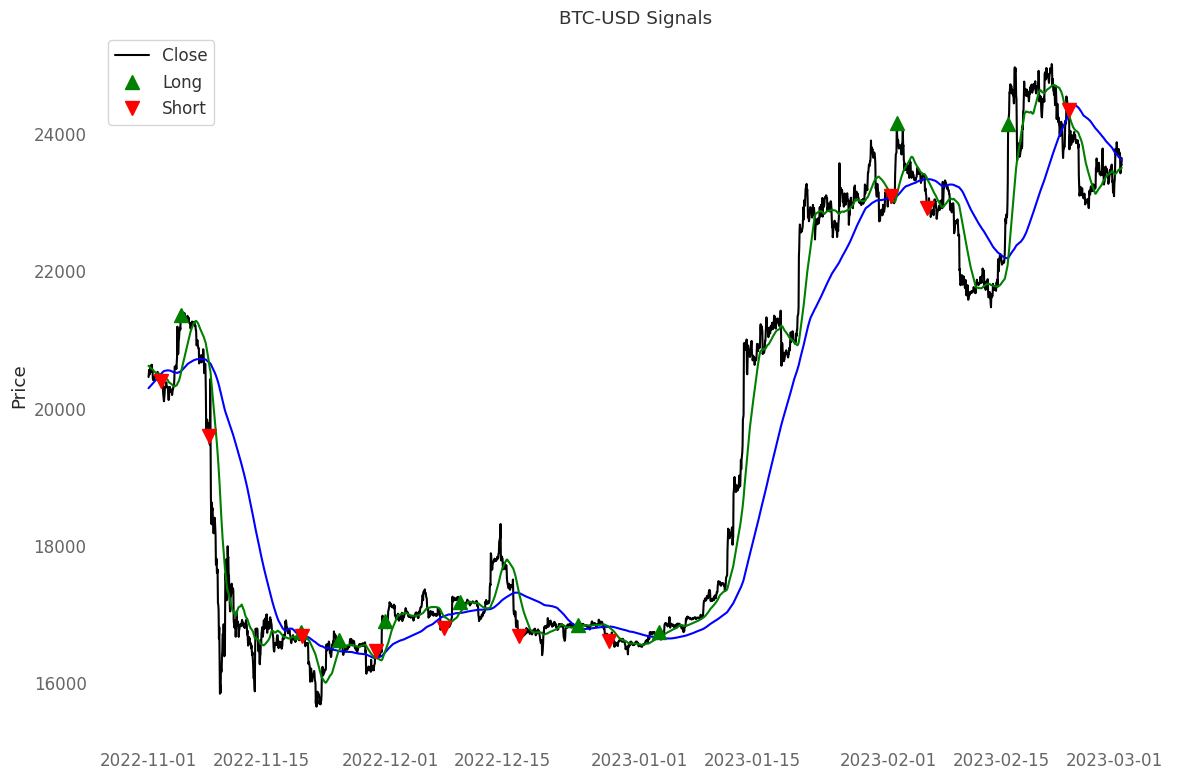

In [7]:
plot_df = df["2022-11-01":"2023-03-01"]

fig, ax1 = plt.subplots(1, figsize=(12, 8), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=10, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=10, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [8]:
# position tracking 
slippage_bps     = 0.5 / 10000 # 0.5BPS

position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Close'] * (1 - slippage_bps) if position == 1 else row['Close'] * (1 + slippage_bps)
            pct_change     = (exit_price - entry_price) / entry_price * 100
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))
        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Close'] * (1 + slippage_bps)
        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Close'] * (1 - slippage_bps)
        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change'])
position_df['cumret'] = position_df['Pct Change'].cumsum()

In [9]:
initial_capital    = 5000.0 # Initial capital in dollars
commission_fee     = 0.04   # 0.04% commission fee per trade
risk_per_trade     = 0.05   # 5% risk per trade

account_balance = initial_capital
balance_changes = []

# Iterate through each trade in the position history
for index, trade in position_df.iterrows():
    pct_change       = trade['Pct Change']
    amount_at_risk   = account_balance * risk_per_trade
    dollar_change    = amount_at_risk  * pct_change
    commission       = amount_at_risk  * (commission_fee/100.0)
    balance_change   = dollar_change - commission
    account_balance += balance_change
    balance_changes.append(balance_change)

position_df['Balance Change'] = balance_changes
position_df['Account History'] = initial_capital + position_df['Balance Change'].cumsum()

position_df['Entry Time'] = pd.to_datetime(position_df['Entry Time'])
position_df = position_df.set_index('Entry Time')

position_df['Account Change'] = position_df['Account History'].pct_change()

In [10]:
position_df

,Exit Time,Entry Price,Exit Price,Pct Change,cumret,Balance Change,Account History,Account Change
Entry Time,,,,,,,,
2022-10-15 13:00:00+00:00,2022-10-15 14:00:00+00:00,19165.477757,19149.993624,-0.080792,-0.080792,-20.297948,4979.702052,NaN
2022-10-16 06:00:00+00:00,2022-10-16 07:00:00+00:00,19129.996577,19137.222438,0.037772,-0.043019,9.305174,4989.007226,0.001869
2022-10-17 19:00:00+00:00,2022-10-17 20:00:00+00:00,19527.931426,19533.697094,0.029525,-0.013494,7.265302,4996.272527,0.001456
2022-10-20 10:00:00+00:00,2022-10-20 11:00:00+00:00,19210.635123,19217.593644,0.036222,0.022728,8.948882,5005.221409,0.001791
2022-10-24 01:00:00+00:00,2022-10-24 02:00:00+00:00,19425.738817,19458.111030,0.166646,0.189374,41.604898,5046.826307,0.008312
...,...,...,...,...,...,...,...,...
2023-09-08 18:00:00+00:00,2023-09-08 19:00:00+00:00,25792.914581,25874.973765,0.318146,-3.913608,60.217088,3850.480133,0.015887
2023-09-10 17:00:00+00:00,2023-09-10 18:00:00+00:00,25688.375673,25725.333077,0.143868,-3.769740,27.621073,3878.101206,0.007173
2023-09-13 18:00:00+00:00,2023-09-13 19:00:00+00:00,26117.467917,26159.565003,0.161184,-3.608556,31.176762,3909.277967,0.008039


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


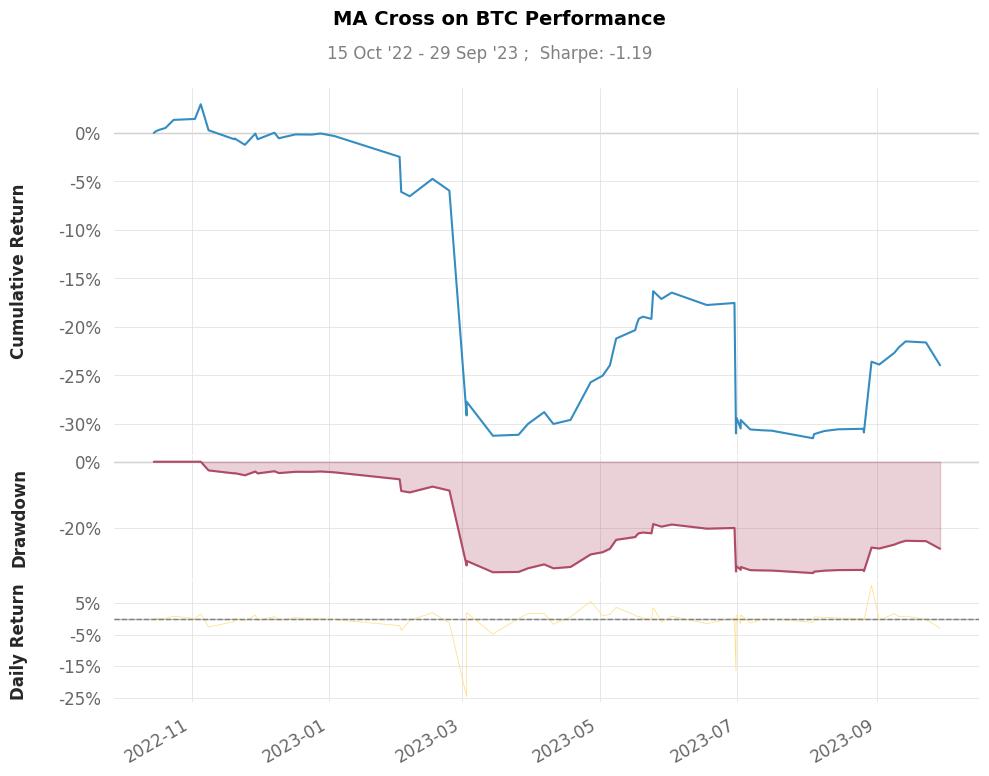

In [11]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on BTC Performance', show=True);

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


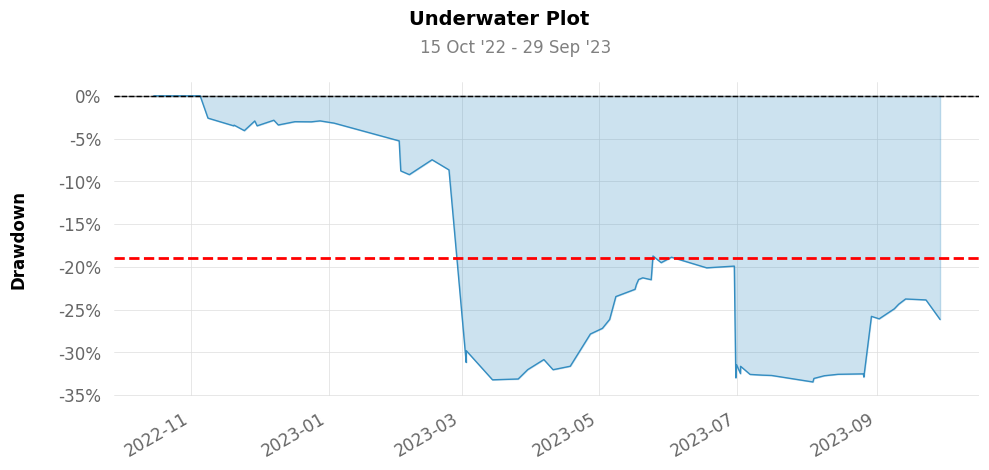

In [12]:
qs.plots.drawdown(position_df['Account Change'])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


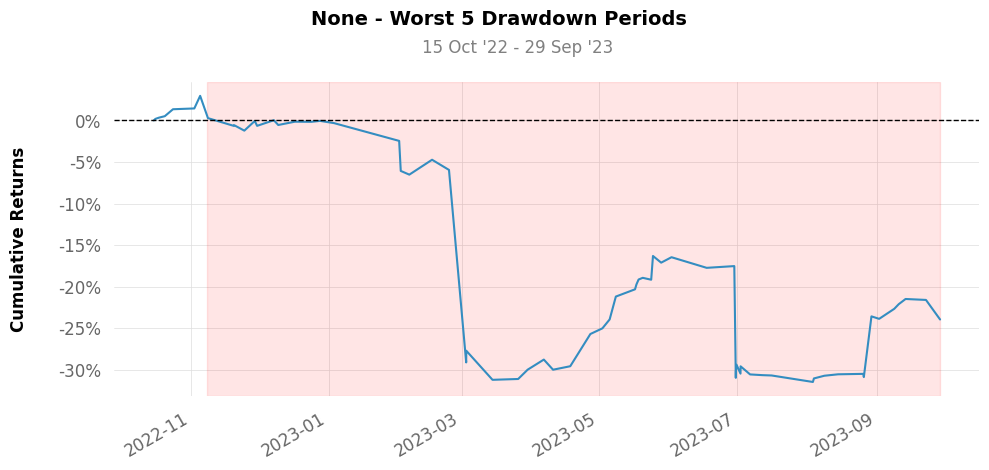

In [13]:
qs.plots.drawdowns_periods(position_df['Account Change'])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


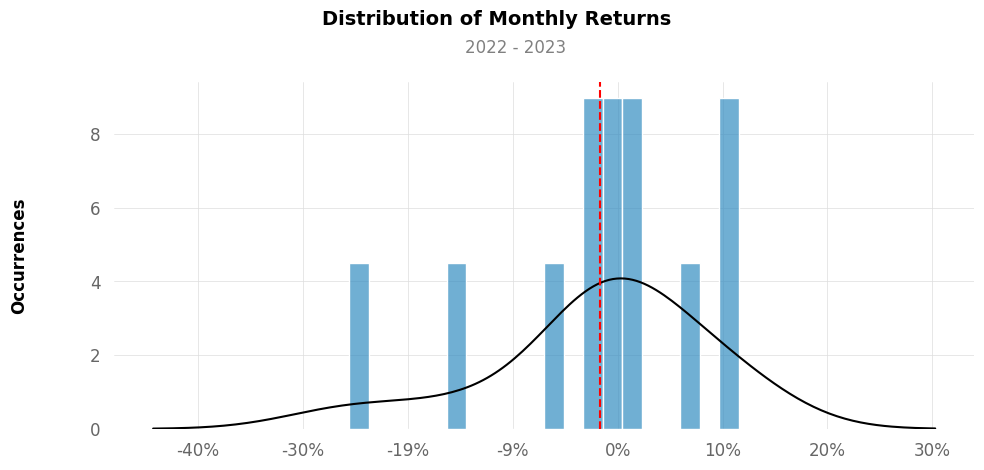

In [14]:
qs.plots.histogram(position_df['Account Change'])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


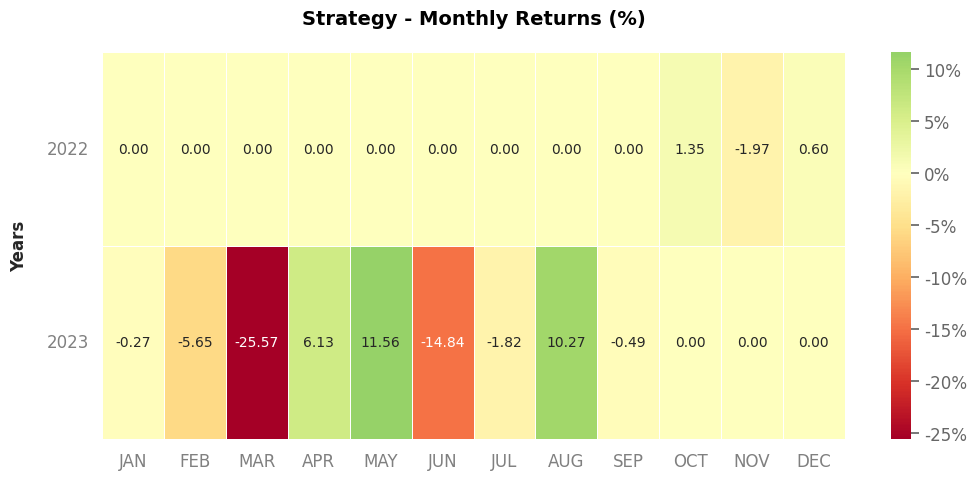

In [15]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [16]:
qs.stats.sharpe(position_df['Account Change'])

-1.1915614300629778